# Chinook Music Store SQL Project

This report presents insights from an exploration of the Chinook Music Store database, hosted locally and queried using Python and SQLite. 

## Goals
- Demonstrate core SQL querying techniques
- Derive business-relevant insights
- Present findings in a clear, readable format

---

## Setup

This block connects to the Chinook SQLite database and performs some preprocessing steps.

I removed non-music/TV genres from the genre, track and invoiceline tables to focus the analysis on music. The new views are `genre_music`, `track_music` and `invoiceline_music`.

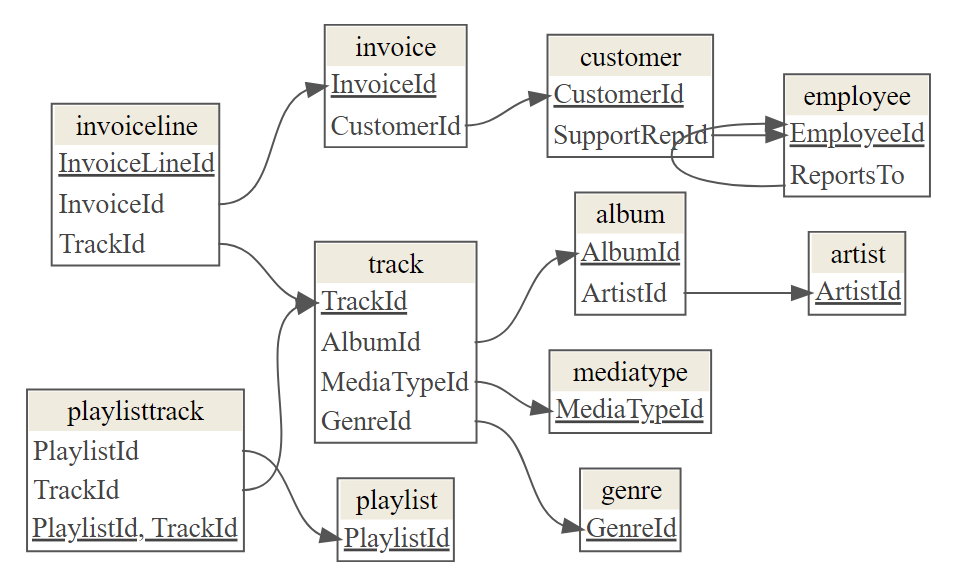

In [40]:
from pathlib import Path
import sys
import pandas as pd
from sqlalchemy import create_engine
from IPython.display import Image, display

repo_root = Path().resolve().parent  

# database path relative to project root
DB_PATH = repo_root / "data" / "Chinook_Sqlite.sqlite"
assert DB_PATH.exists(), f"Database file not found: {DB_PATH}"

# image path
image_path = repo_root / "input" / "ChinookDBStructure.png"
assert image_path.exists(), f"Image file not found: {image_path}"

engine = create_engine(f"sqlite:///{DB_PATH}")

display(Image(filename=str(image_path), width=600, height=400))

# Add scripts folder to path
scripts_path = repo_root / "scripts"
sys.path.append(str(scripts_path))

# run preprocessing which removes non-music/TV genres from tables
import data_prep

# create filtered views in DB
data_prep.prepare_music_views(engine)


In [42]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.colors as mcolors
import seaborn as sns

---
## 1) What are the top 10 best-selling music artists?

Identify which music artists generated the most revenue globally.

In [41]:
# calculating total_global_revenue with a CTE
# filtering for top ten by revenue_rank
# displayed in descending order of total_global_revenue, with tiebreaker of artist_name in ascending order

query = """

WITH total_global_revenue_cte AS(
    SELECT 
         ar.ArtistId,
         ar.Name AS artist_name,
         GROUP_CONCAT(DISTINCT ge.genre_name) AS genres,
         SUM(il.UnitPrice * il.Quantity) AS total_global_revenue,
         DENSE_RANK() OVER(ORDER BY SUM(il.UnitPrice * il.Quantity) DESC) AS revenue_rank   
    FROM invoiceline_music AS il
    JOIN track_music AS tr 
      ON il.TrackID = tr.TrackID
    JOIN album AS al 
      ON tr.AlbumID = al.AlbumID
    JOIN artist AS ar 
      ON al.ArtistID = ar.ArtistID
    JOIN genre_music AS ge 
      ON ge.GenreID = tr.GenreID
    GROUP BY ar.ArtistId,ar.Name
)
SELECT
     artistId,
     artist_name,
     genres,
     total_global_revenue,
     revenue_rank    
FROM total_global_revenue_cte
WHERE revenue_rank <= 10
ORDER BY total_global_revenue DESC, artist_name

"""
artist_sales = pd.read_sql_query(query, engine)
artist_sales

,ArtistId,artist_name,genres,total_global_revenue,revenue_rank
0,90,Iron Maiden,"Rock,Metal,Heavy Metal,Blues",138.60,1
1,150,U2,"Rock,Pop",105.93,2
2,50,Metallica,Metal,90.09,3
3,22,Led Zeppelin,Rock,86.13,4
4,113,Os Paralamas Do Sucesso,Latin,44.55,5
5,58,Deep Purple,Rock,43.56,6
6,82,Faith No More,"Alternative & Punk,Rock",41.58,7
7,81,Eric Clapton,"Blues,Latin",39.60,8
8,124,R.E.M.,"Alternative & Punk,Rock",38.61,9
9,76,Creedence Clearwater Revival,Rock,36.63,10


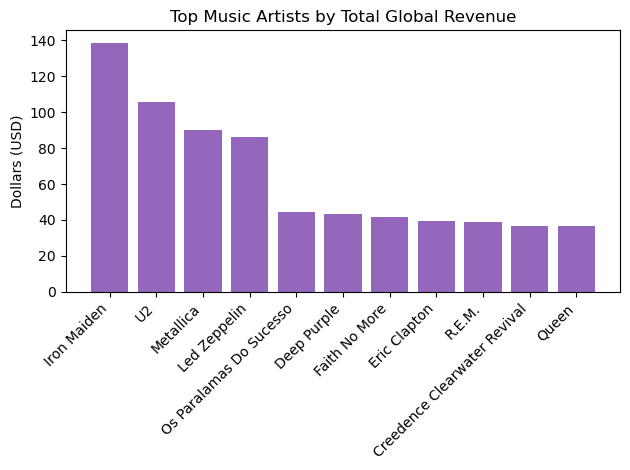

In [43]:
# bar chart of top selling artists
artist_sales['total_global_revenue'] = pd.to_numeric(artist_sales['total_global_revenue'], errors='coerce')
plt.bar(artist_sales['artist_name'], artist_sales['total_global_revenue'], color = mcolors.TABLEAU_COLORS['tab:purple'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Dollars (USD)')
plt.title('Top Music Artists by Total Global Revenue')
plt.rc('xtick', labelsize=9) 
plt.tight_layout()
plt.show()

## Summary Insights

- Rock artists dominate the top artists list suggesting this genre may have the widest appeal globally among the Chinook customer base.
- Metal artists occupy 2 of the top 3 positions.
- The absence of many other genres in this list (e.g., Classical, Jazz) suggests an uneven distribution of revenue across genres.
---
                                                          
## 2) Examine global sales by music genre.

In [44]:
# calculating total global revenue by aggregating over genre with GROUP BY and SUM
query = """

    SELECT 
         ge.genre_name,
         ROUND(SUM(il.UnitPrice * il.Quantity), 2) AS total_global_revenue
    FROM invoiceline_music AS il
    JOIN track_music AS tr 
      ON il.TrackID = tr.TrackID
    JOIN genre_music AS ge 
      ON tr.GenreID = ge.GenreID
    GROUP BY ge.GenreId, ge.genre_name
    ORDER BY total_global_revenue DESC;  

"""
genre_sales = pd.read_sql_query(query, engine)
genre_sales

,genre_name,total_global_revenue
0,Rock,826.65
1,Latin,382.14
2,Metal,261.36
3,Alternative & Punk,241.56
4,Jazz,79.20
5,Blues,60.39
6,R&B/Soul,40.59
7,Classical,40.59
8,Reggae,29.70
9,Pop,27.72


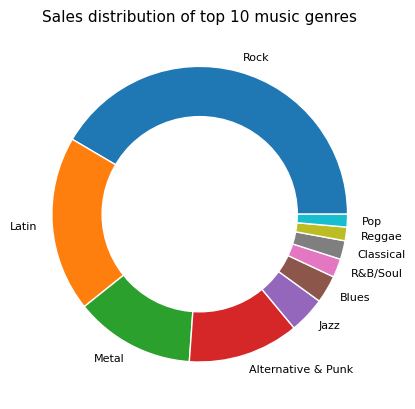

In [39]:
# donut chart of top 10 music genres in terms of total_global_revenue
gs = genre_sales.head(10)
circ = plt.Circle( (0,0), 0.66, color='white')
plt.pie(gs['total_global_revenue'], labels=gs['genre_name'], 
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' },
        textprops = {'fontsize': 8 }
       )
p = plt.gcf()
p.gca().add_artist(circ)
plt.title("Sales distribution of top 10 music genres", fontsize=11)
plt.show()

## Summary Insights

- Similar the genres of the top-selling artists, Rock and Metal are among strongest-selling genres globally.
- Latin and Alternative & Punk also show strong sales suggesting these genres might be supported by a broader base of smaller artists.

---
    
## 3) Examine the monthly time course of global sales.

In [45]:
# extracting year and date values for InvoiceDate
# aggreation on year and month using a SUM with GROUP BY
# CAST include to ensure correct sorting of integers
query = """

    SELECT 
         CAST(strftime('%Y',i.InvoiceDate) AS INTEGER) AS year,
         CAST(strftime('%m',i.InvoiceDate) AS INTEGER) AS month,
         SUM(i.Total) AS revenue
    FROM invoice AS i
    GROUP BY CAST(strftime('%Y',i.InvoiceDate) AS INTEGER),  CAST(strftime('%m',i.InvoiceDate) AS INTEGER)
    ORDER BY CAST(strftime('%Y',i.InvoiceDate) AS INTEGER),  CAST(strftime('%m',i.InvoiceDate) AS INTEGER);

"""
monthly_sales = pd.read_sql_query(query, engine)
monthly_sales.head(12) # showing first year

,year,month,revenue
0,2021,1,35.64
1,2021,2,37.62
2,2021,3,37.62
3,2021,4,37.62
4,2021,5,37.62
5,2021,6,37.62
6,2021,7,37.62
7,2021,8,37.62
8,2021,9,37.62
9,2021,10,37.62


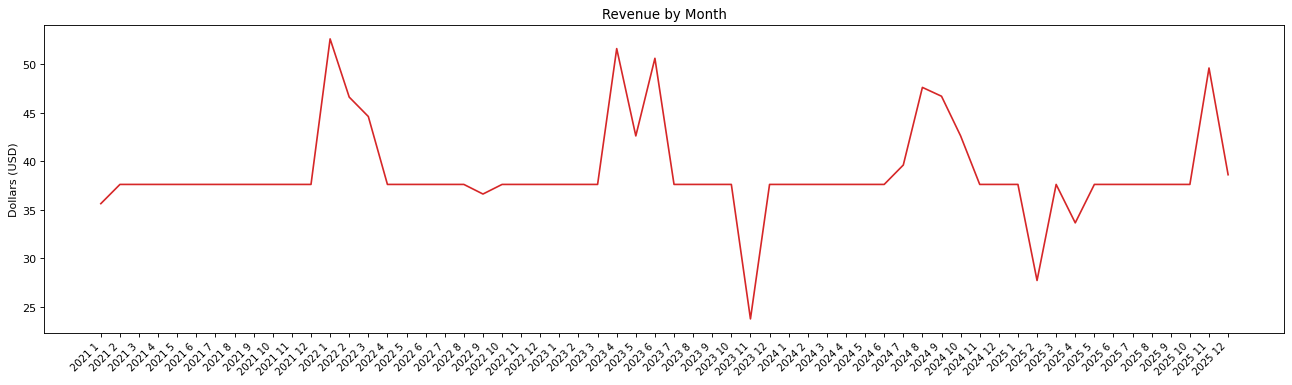

In [46]:
# line chart of global sales my month
figure(figsize=(20, 5), dpi=80)

monthly_sales['revenue'] = pd.to_numeric(monthly_sales['revenue'], errors='coerce')
monthly_sales['year_month'] = monthly_sales['year'].map(str) + ' ' + monthly_sales['month'].map(str)
plt.plot(monthly_sales['year_month' ], monthly_sales['revenue'], color = mcolors.TABLEAU_COLORS['tab:red'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Dollars (USD)')
plt.title('Revenue by Month')
plt.show()

## Summary Insights

This version of Chinook appears to have synthetic revenue data. As shown above, monthly revenue is unrealistically flat across many time ranges, suggesting placeholder values rather than realistic sales trends. Nonetheless, I include this example to demonstrate the use of SQL for grouping and aggregating data by time.

---
## 4) Examine total sales by country.

In [47]:
# calculating total sales by country using invoiceline data because total invoice values in invoice table include non-music genres
query = """

    SELECT 
         c.Country,
         COUNT(DISTINCT c.CustomerID) AS customer_count,
         SUM(il.UnitPrice * il.Quantity) AS total_country_revenue
    FROM customer AS c
    JOIN invoice AS i 
      ON c.CustomerID = i.CustomerID
    JOIN invoiceline_music AS il 
      ON i.InvoiceID = il.InvoiceID
    JOIN track_music AS tr 
      ON il.TrackID = tr.TrackID
    JOIN genre_music AS ge 
      ON tr.GenreID = ge.GenreID
    GROUP BY c.Country
    ORDER BY SUM(il.UnitPrice * il.Quantity) DESC, COUNT(c.CustomerID) DESC; 

"""
country_sales = pd.read_sql_query(query, engine)
country_sales

,Country,customer_count,total_country_revenue
0,USA,13,455.40
1,Canada,8,297.99
2,Brazil,5,186.12
3,France,5,181.17
4,Germany,4,144.54
5,United Kingdom,3,112.86
6,Portugal,2,73.26
7,India,2,71.28
8,Czech Republic,2,60.39
9,Argentina,1,37.62


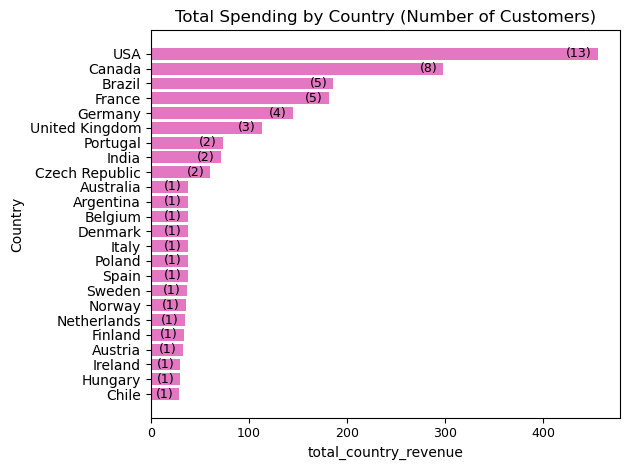

In [48]:
# horizontal bar chart of total spending of each country on music artists
# number of customers per country shown in parenthesis on each bar

# function to add value labels on top of bars
def add_labels(x, y, labels):
    for i in range(len(x)):
        label = f"({labels[i]})"
        plt.text(x[i] - 6, y[i], label, va='center', ha='right', fontsize=9, color='black')

# reorder rows to for visualization
df = country_sales.sort_values(by="total_country_revenue", ascending=True)

# plot horizontal bars
plt.barh(df['Country'], df['total_country_revenue'], color= mcolors.TABLEAU_COLORS['tab:pink'])
y_positions = range(len(df))
plt.ylabel("Country")
add_labels(df['total_country_revenue'].values, y_positions, df['customer_count'].values)
plt.xlabel("total_country_revenue") 
plt.title("Total Spending by Country (Number of Customers)")
plt.tight_layout()
plt.show()

## Summary Insights

- The USA has the most customers and most sales of all countries.
- Most countries have only one customer
---

## 5) Do different countries display distinct genre profiles ?

In [49]:
# calculating total_revenue each genre in each country using GROUP BY and SUM in a CTE
# limited to 4×6 to keep visualization interpretablethe 

query = """
 
WITH country_genre_revenue AS(
-- 1) revenue per country x genre
    SELECT 
         c.Country,
         ge.genre_name,
         SUM(il.UnitPrice * il.Quantity) AS total_revenue
    FROM customer AS c
    JOIN invoice AS i 
      ON c.CustomerID = i.CustomerID
    JOIN invoiceline_music AS il 
      ON i.InvoiceID = il.InvoiceID
    JOIN track_music AS tr 
      ON il.TrackID = tr.TrackID
    JOIN genre_music AS ge 
      ON tr.GenreID = ge.GenreID
    GROUP BY c.Country, ge.genre_name
),
country_revenue AS(
-- 2) total revenue per country (to pick top 6)
    SELECT
         Country,
         SUM(total_revenue) AS country_revenue
    FROM country_genre_revenue
    GROUP BY Country
    ORDER BY country_revenue DESC, Country
    LIMIT 6
),
top_genres AS(
-- 3) selecting top 4 genres per country
    SELECT
         cgr.Country,
         cgr.genre_name,
         cgr.total_revenue,
         ROW_NUMBER() OVER(
            PARTITION BY cgr.Country 
            ORDER BY total_revenue DESC, cgr.genre_name
          ) AS top_rows
    FROM country_genre_revenue AS cgr
    WHERE cgr.Country IN (SELECT Country FROM country_revenue)
)
SELECT
     tg.Country,
     tg.genre_name,
     tg.total_revenue
FROM top_genres AS tg
WHERE tg.top_rows <= 4
ORDER BY tg.Country, tg.total_revenue DESC ;

"""

country_by_genre = pd.read_sql_query(query, engine)
country_by_genre

,Country,genre_name,total_revenue
0,Brazil,Rock,80.19
1,Brazil,Latin,52.47
2,Brazil,Metal,14.85
3,Brazil,Alternative & Punk,6.93
4,Canada,Rock,105.93
5,Canada,Latin,59.40
6,Canada,Metal,39.60
7,Canada,Alternative & Punk,35.64
8,France,Rock,64.35
9,France,Alternative & Punk,30.69


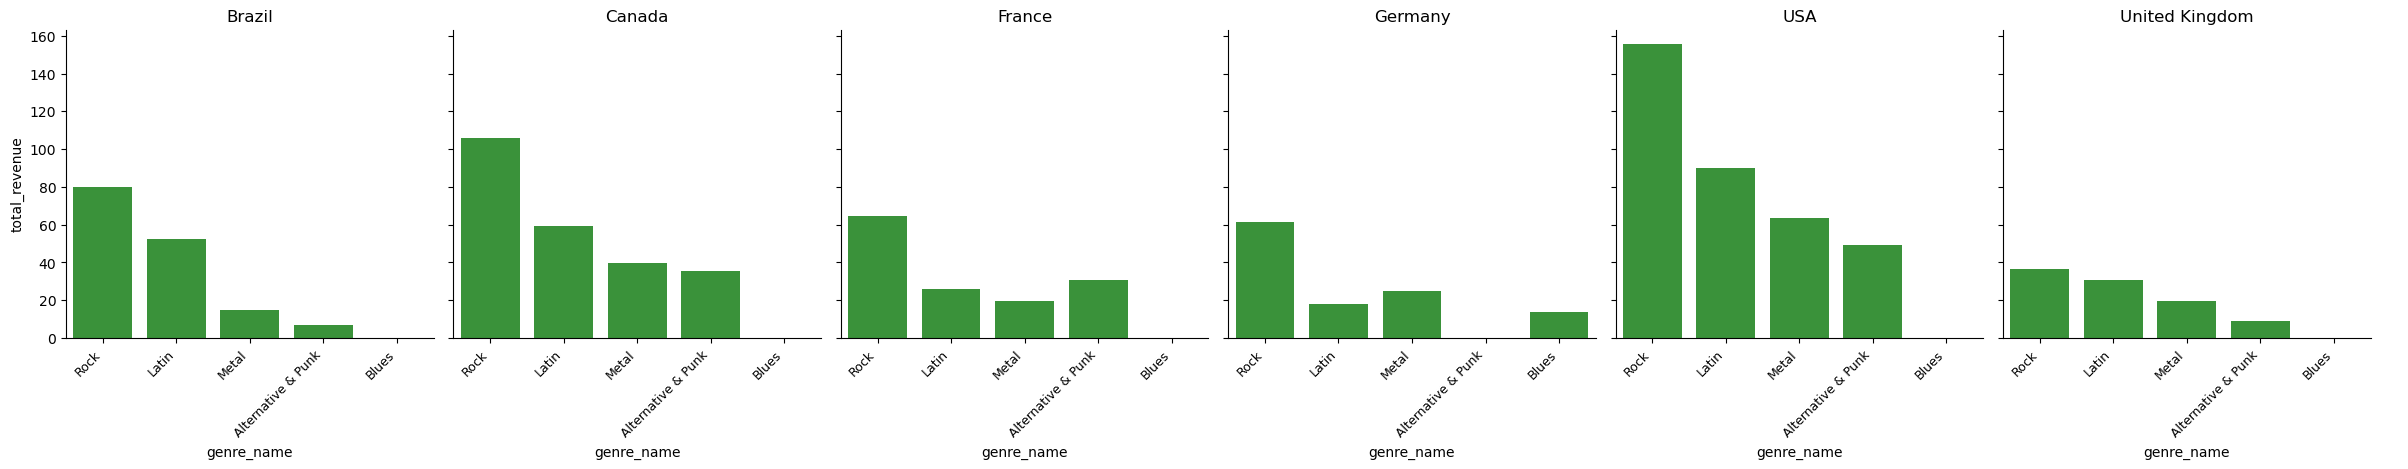

In [50]:
# plot total revenue by genre for each country
p = sns.catplot(
    data=country_by_genre,
    x="genre_name", 
    y="total_revenue", 
    col="Country",
    kind="bar",
    height=4, 
    aspect=1,
    col_wrap = 6,
    color= mcolors.TABLEAU_COLORS['tab:green']
)

for ax in p.axes.flat:
    ax.set_title(ax.get_title().split('=')[1].strip())

for ax in p.axes.flat:  
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')  # align right so they don’t overlap

#plt.tight_layout()   
plt.show()

## Summary Insights

- The Rock genre is the top seller across all six countires, making it the most purchased genre.
- This suggests that the Chinook Music Store has a strong appeal among rock music fans, and that rock is an important feature for customer engagement and revenue globally.
---

## 6) Visualize whether the different countries have unique genre preferences

In [51]:
# convert to numeric
country_by_genre['total_revenue'] = pd.to_numeric(country_by_genre['total_revenue'], errors='coerce')

# Calulate percentages by country
country_by_genre['TotalSalesByCountry'] = country_by_genre.groupby('Country')['total_revenue'].transform('sum')
country_by_genre['Percentage'] = country_by_genre['total_revenue']/country_by_genre['TotalSalesByCountry'] * 100
country_by_genre = country_by_genre.drop(columns = 'TotalSalesByCountry')

display(country_by_genre)

,Country,genre_name,total_revenue,Percentage
0,Brazil,Rock,80.19,51.923077
1,Brazil,Latin,52.47,33.974359
2,Brazil,Metal,14.85,9.615385
3,Brazil,Alternative & Punk,6.93,4.487179
4,Canada,Rock,105.93,44.032922
5,Canada,Latin,59.40,24.691358
6,Canada,Metal,39.60,16.460905
7,Canada,Alternative & Punk,35.64,14.814815
8,France,Rock,64.35,45.774648
9,France,Alternative & Punk,30.69,21.830986


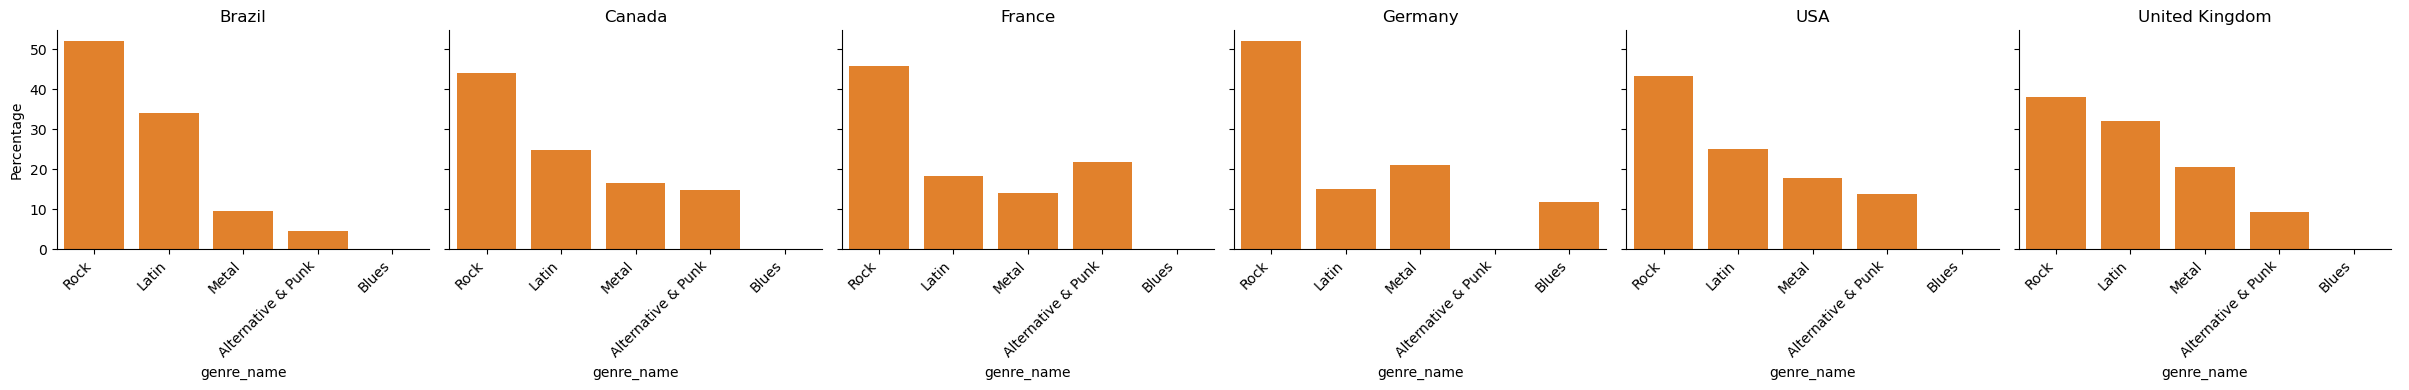

In [29]:
p = sns.catplot(
    data= country_by_genre,
    x="genre_name", y="Percentage", 
    col="Country",
    kind="bar",
    height=4, aspect=1,
    col_wrap = 6,
    color = mcolors.TABLEAU_COLORS['tab:orange']
)

for ax in p.axes.flat:
    ax.set_title(ax.get_title().split('=')[1].strip())

for ax in p.axes.flat:  
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right') 
        
plt.tight_layout()    
plt.show()

## Summary Insights

- Rock is the top-selling genre overall, but country-specific preferences exist.


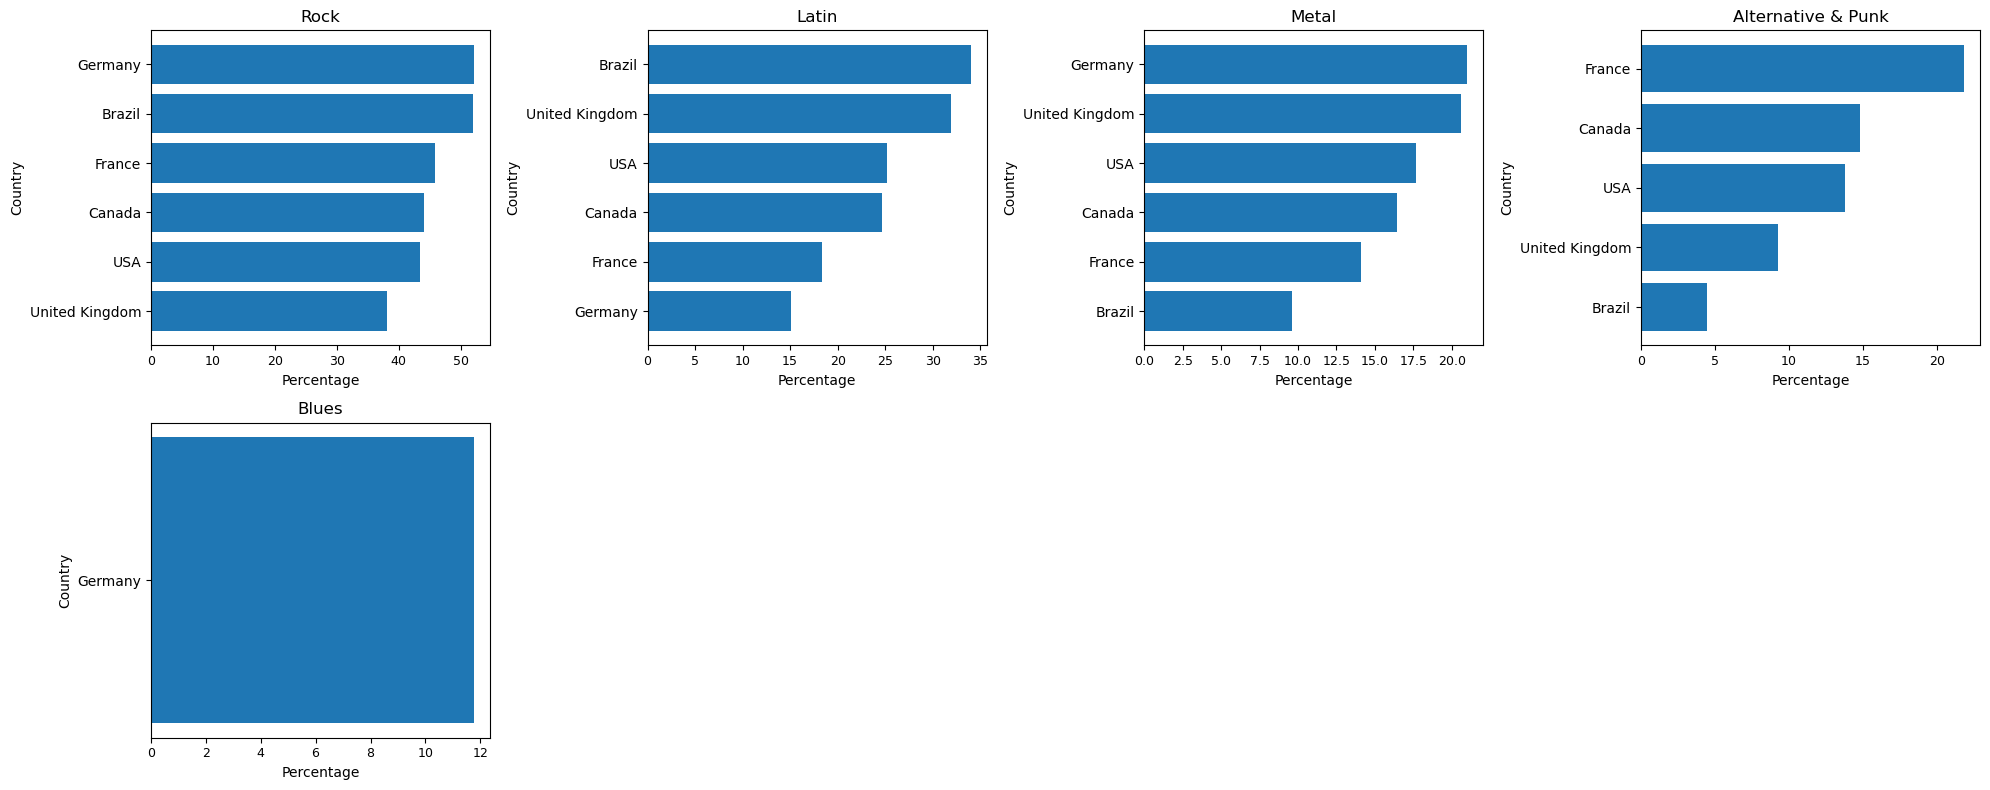

In [53]:
# horizontal bar charts for each genre and the six countries
genres = country_by_genre['genre_name'].unique()
n_cols = 4
n_rows = (len(genres) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, genre in enumerate(genres):
    ax = axes[i]
    sub_df = country_by_genre[country_by_genre['genre_name'] == genre].copy()
    # Sort descending by Percentage
    sub_df = sub_df.sort_values('Percentage', ascending=True)  # ascending=True because barh plots from bottom
    
    ax.barh(sub_df['Country'], sub_df['Percentage'], color= mcolors.TABLEAU_COLORS['tab:blue'])
    ax.set_title(f"{genre}")
    ax.set_xlabel("Percentage")
    ax.set_ylabel("Country")

# Remove unused axes if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Summary Insights

- These patterns support the existence of country specific preferences.
    Examples:
    - DE: shows the highest percentage purchases for both Rock and Metal genres
    - BR: shows the highest percentage of Latin genre purchases
    - FR: leads with the highest percentage of Alternative & Punk genre purchases
- Genre-specific outreach could elevate customer engagement and increase sales in targeted markets.
---

## Main Take Aways

- Rock dominates globally, making it the most relevant genre for Chinook's global marketing efforts. 
- Country-specific preferences in the genres of Alternative & Punk, Latin, and Metal point to opportunities for localized marketing campaigns to increase customer engagement and sales.
- Note: This analysis is based on a small, fictional dataset. It is intended as a technical exercise in SQL and exploratory analysis, not as real-world business advice.

## Follow-up Analysis

For each country, identify the top-selling artists within the two most popular genres over the past two years (2024–2025), so the sales team can target promotions at artists with recent strong sales.
Note: This version of the Chinook data bases is 

In [58]:
# identify the top artist for the top two selling genreas in each country across 2024-2025
query = """

WITH top_recent_genres AS(
    SELECT 
        i.BillingCountry AS Country,
        ge.GenreName AS Genre,
        ROUND(SUM(il.UnitPrice * il.Quantity), 2) AS TotalSales,
        RANK() OVER(PARTITION BY i.BillingCountry ORDER BY ROUND(SUM(il.UnitPrice * il.Quantity), 2) DESC) AS Genre_Rank
    FROM invoice AS i
    JOIN invoiceline_music AS il ON i.InvoiceID = il.InvoiceID
    JOIN track_music AS tr ON il.TrackID = tr.TrackID
    JOIN genre_music AS ge ON tr.GenreID = ge.GenreID
    WHERE YEAR(i.InvoiceDate) >= 2024                                       -- using data from 2024 and 2025; it is placeholder data, hence 2025 has data for the whole year
    GROUP BY i.BillingCountry, ge.GenreName
    ORDER BY Country, Genre
), 
top_recent_artists AS(
    SELECT 
        i.BillingCountry AS Country,
        ge.GenreName AS Genre,
        ar.Name AS Artist,
        ROUND(SUM(il.UnitPrice * il.Quantity), 2) AS TotalSales,
        RANK() OVER(PARTITION BY i.BillingCountry, ge.GenreName ORDER BY ROUND(SUM(il.UnitPrice * il.Quantity), 2) DESC) AS Artist_Rank
    FROM invoice AS i
    JOIN invoiceline_music AS il ON i.InvoiceID = il.InvoiceID
    JOIN track_music AS tr ON il.TrackID = tr.TrackID
    JOIN genre_music AS ge ON tr.GenreID = ge.GenreID
    JOIN album AS al ON tr.AlbumId = al.AlbumId
    JOIN artist AS ar ON al.ArtistId = ar.ArtistId 
    WHERE YEAR(i.InvoiceDate) >= 2024                                       -- using data from 2024 and 2025; it is placeholder data, hence 2025 has data for the whole year
    GROUP BY i.BillingCountry, ge.GenreName, ar.Name
    ORDER BY Country, Genre
)

SELECT ta.Country,
       ta.Genre,
       ta.Artist
FROM top_recent_artists AS ta
JOIN top_recent_genres AS tg ON ta.Country = tg.Country AND ta.Genre = tg.Genre
WHERE tg.Genre_Rank <= 2
  AND ta.Artist_Rank = 1;

"""

top_recent_artists_of_top_recent_genres = pd.read_sql_query(query, engine)
top_recent_artists_of_top_recent_genres

,Country,Genre,Artist
0,Argentina,Alternative & Punk,Titãs
1,Argentina,Latin,Tim Maia
2,Australia,Metal,Iron Maiden
3,Australia,Rock,Iron Maiden
4,Australia,Rock,U2
5,Austria,R&B/Soul,Amy Winehouse
6,Austria,Rock,The Who
7,Belgium,Alternative & Punk,Smashing Pumpkins
8,Belgium,R&B/Soul,Marvin Gaye
9,Brazil,Latin,Os Paralamas Do Sucesso
